In [103]:
dataset_path = "C:\\Users\\psmsu\\Documents\\PERS\\VIT\\CAPSTONE\\dataset\\mendeley dataset"
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.optim import Adam
device = torch.device('cpu')

## Load dataset and apply transformations

In [93]:
dataset = ImageFolder(dataset_path, T.Compose([
    T.Resize((150,150)),
    T.ToTensor(),
]))

## Splitting the dataset as train, validation and test

In [94]:
from torch.utils.data import random_split
train_len = int(0.75*len(dataset))
test_len = int(0.15*len(dataset))
validate_len = int(0.1*len(dataset))
train, validate, test = random_split(dataset, (train_len, validate_len, test_len+1))

## Testing transforms with a sample image

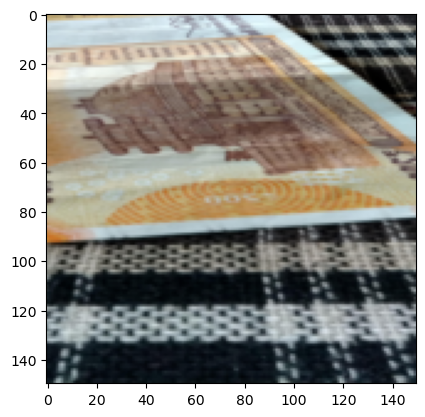

In [95]:
path = r"C:\Users\psmsu\Documents\PERS\VIT\CAPSTONE\dataset\mendeley dataset\Rs.200\200_original_IMG_20190422_063824142_HDR.jpg_60d7e8f9-95e3-45db-806b-b1c17fcdfbc8.jpg"
from PIL import Image
img = Image.open(path)
plt.imshow(T.Resize((150,150))(img))

## Dataloaders

In [96]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train, batch_size=256, shuffle=True)
test_dataloader = DataLoader(dataset=test, batch_size=256, shuffle=True)

## CNN network

In [112]:
import torch.nn as nn
class ConvNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ConvNet, self).__init__()

        self.network = nn.Sequential(
            
            #inputshape = (256, 3, 150, 150)
            nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1),
            #(256,12,150,150)
            nn.BatchNorm2d(num_features=12),
            #(256,12,150,150)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #(256,12,75,75)

            nn.Conv2d(12,20, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            #(256,20,75,75)

            nn.Conv2d(20,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            #(256,32,75,75)
            nn.Flatten(),
            nn.Linear(32*75*75,num_classes)
        )
    def forward(self, input):
        return self.network(input)
        

## Training

In [114]:
model =ConvNet(num_classes=7).to(device)


In [115]:
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [116]:
 num_epochs = 10
 train_count = len(train)
 test_count = len(test)

In [117]:
best_accuracy = 0.0

for epoch in range(num_epochs):
    #training
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss=loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss +=loss.cpu().data*images.size(0)
        _,prediction = torch.max(outputs.data,1)

        train_accuracy += int(torch.sum(prediction==labels.data))
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count


    #testing
    model.eval()
    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_dataloader):
        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    test_accuracy = test_accuracy/test_count

    print('Epoch: '+str(epoch)+' Train loss: ' + str(int(train_loss))+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    #Save model
    if(test_accuracy>best_accuracy):
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

Epoch: 0 Train loss: 30 Train Accuracy: 0.28471158754466563 Test Accuracy: 0.13456632653061223
Epoch: 1 Train loss: 3 Train Accuracy: 0.5065084226646248 Test Accuracy: 0.4100765306122449
Epoch: 2 Train loss: 2 Train Accuracy: 0.6013272077590608 Test Accuracy: 0.4164540816326531
Epoch: 3 Train loss: 1 Train Accuracy: 0.7404287901990811 Test Accuracy: 0.48596938775510207
Epoch: 4 Train loss: 0 Train Accuracy: 0.8098519652884124 Test Accuracy: 0.5644132653061225
Epoch: 5 Train loss: 0 Train Accuracy: 0.8705972434915773 Test Accuracy: 0.5707908163265306
Epoch: 6 Train loss: 0 Train Accuracy: 0.9236855538540072 Test Accuracy: 0.6403061224489796
Epoch: 7 Train loss: 0 Train Accuracy: 0.9687340479836651 Test Accuracy: 0.6045918367346939
Epoch: 8 Train loss: 0 Train Accuracy: 0.9903011740684022 Test Accuracy: 0.6683673469387755
Epoch: 9 Train loss: 0 Train Accuracy: 0.9961715160796325 Test Accuracy: 0.6747448979591837


In [ ]:
import seaborn as sns
import numpy as np

with torch.no_grad():
    r = []
    p = []
    for i, (images, labels) in enumerate(test_dataloader):
        r+=labels.tolist()
        pred = model(images)
        for x in pred:
            p.append(int(torch.argmax(x, dim=0)))
print(r)
print(p)
cp = np.stack([np.asarray(p), np.asarray(r)]).T
confusion_matrix = np.zeros((7,7), dtype=int)
for pair in cp:
    x,y = pair.tolist()
    confusion_matrix[x,y] = confusion_matrix[x,y]+1

<Axes: >

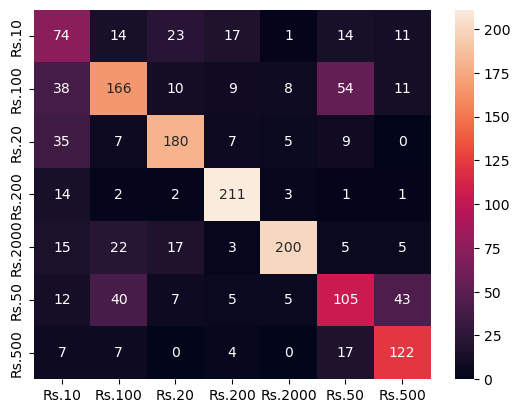

In [191]:
sns.heatmap(confusion_matrix, annot=True, xticklabels=dataset.classes,yticklabels=dataset.classes,fmt=".4g")

In [124]:
nmodel = ConvNet()
nmodel.load_state_dict(torch.load(r"C:\Users\psmsu\Documents\PERS\VIT\CAPSTONE\trial1\best_checkpoint.model"))
nmodel.eval()

ConvNet(
  (network): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=180000, out_features=7, bias=True)
  )
)